# Experiments with Dataset

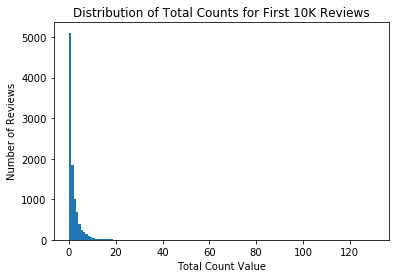

The number of reviews with a total count of 0 is: 5108
The number of reviews with a total count of 1 is: 1851
The number of reviews with a total count of 2 is: 1005
The number of reviews with a total count of 3 is: 694
The number of reviews with a total count of 4 is: 385
The number of reviews with a total count of 5 is: 253
The number of reviews with a total count of 6 is: 184
The number of reviews with a total count of 7 is: 131
The number of reviews with a total count of 8 is: 87
The number of reviews with a total count of 9 is: 57
The number of reviews with a total count of 10 is: 45
The number of reviews with a total count of 11 is: 28
The number of reviews with a total count of 12 is: 26
The number of reviews with a total count of 13 is: 26
The number of reviews with a total count of 14 is: 11
The number of reviews with a total count of 15 is: 20
The number of reviews with a total count of 16 is: 17
The number of reviews with a total count of 17 is: 10
The number of reviews with 

In [3]:
#Referenced https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html
#Referenced https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html
#Referenced https://stackoverflow.com/questions/16958430/matplotlib-histograms-and-labels

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

totalCounts = []
for i in range(51):
    data = pd.read_json("ReviewData/yelp_academic_dataset_review" + str(i+1) + ".json") #Read the appropriate file
    #So we can find the distribution of each count
    usefulCounts = data["useful"]
    funnyCounts = data["funny"]
    coolCounts = data["cool"]
    #Get a total of all the counts:
    for i in range(len(usefulCounts)):
        totalCounts.append(usefulCounts[i] + funnyCounts[i] + coolCounts[i])

plt.hist(totalCounts, bins=sorted(list(set(totalCounts))))
plt.title("Distribution of Total Counts for First 10K Reviews")
plt.xlabel("Total Count Value")
plt.ylabel("Number of Reviews")
plt.show()

allCounts = list(set(totalCounts))
reviewsWithEachCount = dict()
for i in allCounts:
    reviewsWithEachCount[i] = 0

for i in allCounts:
    for j in totalCounts:
        if (j == i):
            reviewsWithEachCount[i] = reviewsWithEachCount[i] + 1

for i in reviewsWithEachCount.keys():
    print("The number of reviews with a total count of " + str(i) + " is: " + str(reviewsWithEachCount[i]))

## Reading Business Data

In [4]:
businessData = pd.read_json("YelpData/yelp_academic_dataset_business.json", lines=True)
#print(sorted(set(businessData["review_count"])))

In [5]:
#Referenced https://pandas.pydata.org/pandas-docs/stable/indexing.html
#Referenced https://stackoverflow.com/questions/14639496/python-numpy-array-of-arbitrary-length-strings
#Referenced https://docs.python.org/3/tutorial/datastructures.html
#Referenced http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html#pandas.DataFrame

%matplotlib inline

data = pd.read_json("ReviewData/yelp_academic_dataset_review1.json") #Read the appropriate file

#Create a list of useful columns
columns = list(data.columns)
columns.remove("business_id")
columns.remove("user_id")
columns.remove("review_id")
columns.remove("stars")
columns.remove("date")

trainData = np.ndarray(shape=(10000,len(columns)+2), dtype=object) #Include all given data, plus our classes
offset = 0 #This is used to make sure we don't overwrite arrays
threshold = 2 #Given review r with total count k, if k <= threshold, r is not influential

for i in range(51):
    data = pd.read_json("ReviewData/yelp_academic_dataset_review" + str(i+1) + ".json") #Read the appropriate file)
    #So we can find the distribution of each count
    usefulCounts = data["useful"]
    funnyCounts = data["funny"]
    coolCounts = data["cool"]
    #Now we create training data:
    for j in range(len(usefulCounts)):
        #First get the total count (which we want):
        total = usefulCounts[j] + funnyCounts[j] + coolCounts[j]
        for k in range(len(columns)): #Copy all existing data
            trainData[j+offset,k] = data.loc[j,columns[k]]
            
        trainData[j+offset,len(columns)] = total #Now record the total count
        
        #Classify by total count:
        if (total <= threshold): #If in the class of less influential reviews
            trainData[j+offset,len(columns)+1] = False
        else:
            trainData[j+offset,len(columns)+1] = True
            
    #Update offset so as to not overwrite data:
    offset = offset + len(usefulCounts)

#Now prepare the final dataframe by first prepping the columns
listOfFinalCols = columns.copy()
listOfFinalCols.append("Total")
listOfFinalCols.append("Influential")

trainData = pd.DataFrame(data=trainData, columns=listOfFinalCols, dtype=object)
#Now we've got training data for what we want to do!

## Bag of Words Experiments

In [4]:
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
%matplotlib inline
import sklearn.feature_extraction.text as txt
import copy

#In a bag of words, it makes sense to remove stopwords (as those are too common) and remove punctuation, as we are
#looking mainly for the words, not random punctuation signs.
#We remove these things from the text as well.

text = trainData["text"]

for word in text[i].split(): #Every temp[i] is a sentence
    for char in word:
        if char in [".", "?", ","]:
            text[i] = text[i].replace(char, "")
                    
wordsVect = txt.CountVectorizer(stop_words="english")
bagOfWordsTrain = wordsVect.fit_transform(text)

### Naive Bayes for First 5k Reviews Using Bag of Words

In [34]:
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

%matplotlib inline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

#Binarize the labels to more clearly define True positives and True negatives
binarizer = LabelBinarizer(neg_label=False, pos_label=True)
binarizer.fit(list(trainData["Influential"]))
newTargets = np.ndarray.flatten(binarizer.transform(list(trainData["Influential"])))

#Do a single fit on first 5k reviews
naiveBayes = GaussianNB()
# naiveBayes.fit(bagOfWordsTrain.toarray(), newTargets)
# pred = naiveBayes.predict(bagOfWordsTrain.toarray()[:5000])
# trueNeg, falsePos, falseNeg, truePos = confusion_matrix(newTargets[:5000], pred).ravel()
# print("So the accuracy on the first 5k reviews is: " + str(float(truePos+trueNeg)/(trueNeg+falsePos+falseNeg+truePos)))
# print("So the precision on the first 5k reviews is: " + str(float(truePos)/(falsePos+truePos)))
# print("So the recall on the first 5k reviews is: " + str(float(truePos)/(falseNeg+truePos)))

#Get some feedback
print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=naiveBayes, X=bagOfWordsTrain.toarray()[:5000], y=newTargets[:5000], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=naiveBayes, X=bagOfWordsTrain.toarray()[:5000], y=newTargets[:5000], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=naiveBayes, X=bagOfWordsTrain.toarray()[:5000], y=newTargets[:5000], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.48702595  0.4491018   0.45        0.484       0.49        0.458       0.506
  0.482       0.46292585  0.43286573]
Using 10-fold cross validation, we get the following precision scores: 
[ 0.14285714  0.20141343  0.164       0.18410042  0.20634921  0.172
  0.23282443  0.1984127   0.18110236  0.16853933]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.28037383  0.53271028  0.38317757  0.41121495  0.48598131  0.40186916
  0.57009346  0.46728972  0.43396226  0.4245283 ]


### Naive Bayes Using Last 5k Reviews Using Bag of Words

In [35]:
print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=naiveBayes, X=bagOfWordsTrain.toarray()[5000:], y=newTargets[5000:], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=naiveBayes, X=bagOfWordsTrain.toarray()[5000:], y=newTargets[5000:], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=naiveBayes, X=bagOfWordsTrain.toarray()[5000:], y=newTargets[5000:], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.51896208  0.54091816  0.558       0.526       0.546       0.538       0.516
  0.542       0.51703407  0.501002  ]
Using 10-fold cross validation, we get the following precision scores: 
[ 0.17272727  0.14054054  0.17368421  0.1728972   0.17821782  0.17156863
  0.1563981   0.16326531  0.11640212  0.14746544]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.39175258  0.26804124  0.34020619  0.3814433   0.37113402  0.36082474
  0.34020619  0.32989691  0.22916667  0.33333333]


### Random Forest for First 5k Reviews Using Bag of Words

In [36]:
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

#Binarize the labels to more clearly define True positives and True negatives
binarizer = LabelBinarizer(neg_label=False, pos_label=True)
binarizer.fit(list(trainData["Influential"]))
newTargets = np.ndarray.flatten(binarizer.transform(list(trainData["Influential"])))

#Do a single fit on first 5k reviews
forest = RandomForestClassifier()
# forest.fit(bagOfWordsTrain.toarray(), newTargets)
# pred = forest.predict(bagOfWordsTrain.toarray()[:5000])
# trueNeg, falsePos, falseNeg, truePos = confusion_matrix(newTargets[:5000], pred).ravel()
# print("So the accuracy on the first 5k reviews is: " + str(float(truePos+trueNeg)/(trueNeg+falsePos+falseNeg+truePos)))
# print("So the precision on the first 5k reviews is: " + str(float(truePos)/(falsePos+truePos)))
# print("So the recall on the first 5k reviews is: " + str(float(truePos)/(falseNeg+truePos)))

print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=forest, X=bagOfWordsTrain.toarray()[:5000], y=newTargets[:5000], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=forest, X=bagOfWordsTrain.toarray()[:5000], y=newTargets[:5000], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=forest, X=bagOfWordsTrain.toarray()[:5000], y=newTargets[:5000], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.79840319  0.77644711  0.788       0.786       0.774       0.78        0.788
  0.782       0.78757515  0.77955912]
Using 10-fold cross validation, we get the following precision scores: 
[ 0.5625      0.46153846  0.5         0.6         0.375       0.26666667
  0.5         0.38461538  0.66666667  0.56      ]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.17757009  0.02803738  0.06542056  0.05607477  0.04672897  0.04672897
  0.05607477  0.03738318  0.08490566  0.10377358]


### Random Forest for Last 5k Reviews Using Bag of Words

In [37]:
print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=forest, X=bagOfWordsTrain.toarray()[5000:], y=newTargets[5000:], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=forest, X=bagOfWordsTrain.toarray()[5000:], y=newTargets[5000:], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=forest, X=bagOfWordsTrain.toarray()[5000:], y=newTargets[5000:], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.79640719  0.80439122  0.8         0.806       0.808       0.798       0.812
  0.796       0.81162325  0.80360721]
Using 10-fold cross validation, we get the following precision scores: 
[ 0.41666667  0.45833333  0.09090909  0.5         0.6         0.58333333
  0.4         0.33333333  0.46153846  0.41666667]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.04123711  0.08247423  0.02061856  0.04123711  0.04123711  0.02061856
  0.03092784  0.08247423  0.0625      0.0625    ]


### Logistic Regression for First 5k Reviews Using Bag of Words

In [38]:
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

#Binarize the labels to more clearly define True positives and True negatives
binarizer = LabelBinarizer(neg_label=False, pos_label=True)
binarizer.fit(list(trainData["Influential"]))
newTargets = np.ndarray.flatten(binarizer.transform(list(trainData["Influential"])))

#Do a single fit on first 5k reviews
regr = LogisticRegression()
# regr.fit(bagOfWordsTrain.toarray(), newTargets)
# pred = regr.predict(bagOfWordsTrain.toarray()[:5000])
# trueNeg, falsePos, falseNeg, truePos = confusion_matrix(newTargets[:5000], pred).ravel()
# print("So the accuracy on the first 5k reviews is: " + str(float(truePos+trueNeg)/(trueNeg+falsePos+falseNeg+truePos)))
# print("So the precision on the first 5k reviews is: " + str(float(truePos)/(falsePos+truePos)))
# print("So the recall on the first 5k reviews is: " + str(float(truePos)/(falseNeg+truePos)))

print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=regr, X=bagOfWordsTrain.toarray()[:5000], y=newTargets[:5000], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=regr, X=bagOfWordsTrain.toarray()[:5000], y=newTargets[:5000], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=regr, X=bagOfWordsTrain.toarray()[:5000], y=newTargets[:5000], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.77045908  0.75449102  0.756       0.736       0.738       0.742       0.752
  0.754       0.77955912  0.75551102]
Using 10-fold cross validation, we get the following precision scores: 
[ 0.45454545  0.38571429  0.4137931   0.29508197  0.25        0.31666667
  0.33962264  0.32608696  0.46551724  0.35714286]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.37383178  0.25233645  0.3364486   0.1682243   0.11214953  0.17757009
  0.1682243   0.14018692  0.25471698  0.18867925]


### Logistic Regression for Last 5k Reviews Using Bag of Words

In [39]:
print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=regr, X=bagOfWordsTrain.toarray()[5000:], y=newTargets[5000:], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=regr, X=bagOfWordsTrain.toarray()[5000:], y=newTargets[5000:], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=regr, X=bagOfWordsTrain.toarray()[5000:], y=newTargets[5000:], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.74850299  0.76247505  0.756       0.806       0.76        0.758       0.788
  0.764       0.76953908  0.7995992 ]
Using 10-fold cross validation, we get the following precision scores: 
[ 0.28985507  0.35526316  0.22222222  0.5         0.26530612  0.3125
  0.36363636  0.26666667  0.35820896  0.45454545]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.20618557  0.27835052  0.10309278  0.22680412  0.13402062  0.20618557
  0.12371134  0.12371134  0.25        0.20833333]


### SVM for First 5k Reviews Using Bag of Words

In [48]:
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

#Binarize the labels to more clearly define True positives and True negatives
binarizer = LabelBinarizer(neg_label=False, pos_label=True)
binarizer.fit(list(trainData["Influential"]))
newTargets = np.ndarray.flatten(binarizer.transform(list(trainData["Influential"])))

#Do a single fit on first 5k reviews
suppVecMach = SVC(kernel="linear")
# suppVecMach.fit(bagOfWordsTrain.toarray()[:5000], newTargets[:5000])
# pred = suppVecMach.predict(bagOfWordsTrain.toarray()[:5000])
# trueNeg, falsePos, falseNeg, truePos = confusion_matrix(newTargets[:5000], pred).ravel()
# print("So the accuracy on the first 5k reviews is: " + str(float(truePos+trueNeg)/(trueNeg+falsePos+falseNeg+truePos)))
# print("So the precision on the first 5k reviews is: " + str(float(truePos)/(falsePos+truePos)))
# print("So the recall on the first 5k reviews is: " + str(float(truePos)/(falseNeg+truePos)))

print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=suppVecMach, X=bagOfWordsTrain[:5000], y=newTargets[:5000], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=suppVecMach, X=bagOfWordsTrain[:5000], y=newTargets[:5000], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=suppVecMach, X=bagOfWordsTrain[:5000], y=newTargets[:5000], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.73253493  0.71457086  0.714       0.7         0.71        0.7         0.716
  0.74        0.73547094  0.71142285]
Using 10-fold cross validation, we get the following precision scores: 
[ 0.37837838  0.32692308  0.35245902  0.27368421  0.25        0.25287356
  0.30337079  0.34246575  0.35869565  0.28888889]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.39252336  0.31775701  0.40186916  0.24299065  0.17757009  0.20560748
  0.25233645  0.23364486  0.31132075  0.24528302]


### SVM For Last 5k Reviews Using Bag of Words

In [42]:
print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=suppVecMach, X=bagOfWordsTrain[5000:], y=newTargets[5000:], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=suppVecMach, X=bagOfWordsTrain[5000:], y=newTargets[5000:], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=suppVecMach, X=bagOfWordsTrain[5000:], y=newTargets[5000:], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.72055888  0.72055888  0.724       0.766       0.732       0.728       0.76
  0.728       0.73747495  0.75551102]
Using 10-fold cross validation, we get the following precision scores: 
[ 0.28282828  0.30630631  0.24050633  0.36486486  0.26582278  0.27586207
  0.35064935  0.25925926  0.32323232  0.33333333]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.28865979  0.35051546  0.19587629  0.27835052  0.21649485  0.24742268
  0.27835052  0.21649485  0.33333333  0.27083333]


## TF-IDF Experiments

In [7]:
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
import sklearn.feature_extraction.text as txt

#In a bag of words, it makes sense to remove stopwords (as those are too common) and remove punctuation, as we are
#looking mainly for the words, not random punctuation signs.
#We remove these things from the text as well.
temp = trainData["text"].copy() #So we do not modify text directly

for i in temp.keys():
        for word in temp[i].split(): #Every temp[i] is a sentence
            for char in word:
                if char in [".", "?", ","]:
                    temp[i] = temp[i].replace(char, "")

tfIdfVect = txt.TfidfVectorizer()
tfIdfScores = tfIdfVect.fit_transform(temp)

### Naive Bayes for First 5k Reviews Using TF-IDF Scores

In [8]:
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

%matplotlib inline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

#Binarize the labels to more clearly define True positives and True negatives
binarizer = LabelBinarizer(neg_label=False, pos_label=True)
binarizer.fit(list(trainData["Influential"]))
newTargets = np.ndarray.flatten(binarizer.transform(list(trainData["Influential"])))

#Do a single fit on first 5k reviews
naiveBayes = GaussianNB()
# naiveBayes.fit(bagOfWordsTrain.toarray(), newTargets)
# pred = naiveBayes.predict(bagOfWordsTrain.toarray()[:5000])
# trueNeg, falsePos, falseNeg, truePos = confusion_matrix(newTargets[:5000], pred).ravel()
# print("So the accuracy on the first 5k reviews is: " + str(float(truePos+trueNeg)/(trueNeg+falsePos+falseNeg+truePos)))
# print("So the precision on the first 5k reviews is: " + str(float(truePos)/(falsePos+truePos)))
# print("So the recall on the first 5k reviews is: " + str(float(truePos)/(falseNeg+truePos)))

#Get some feedback
print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=naiveBayes, X=tfIdfScores.toarray()[:5000], y=newTargets[:5000], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=naiveBayes, X=tfIdfScores.toarray()[:5000], y=newTargets[:5000], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=naiveBayes, X=tfIdfScores.toarray()[:5000], y=newTargets[:5000], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.51297405  0.4750499   0.488       0.488       0.504       0.464       0.502
  0.504       0.4749499   0.46092184]
Using 10-fold cross validation, we get the following precision scores: 
[ 0.14507772  0.20895522  0.17180617  0.18025751  0.2         0.16872428
  0.21825397  0.20502092  0.17226891  0.16734694]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.26168224  0.52336449  0.36448598  0.39252336  0.43925234  0.38317757
  0.51401869  0.45794393  0.38679245  0.38679245]


### Naive Bayes for Last 5k Reviews Using TF-IDF Scores

In [9]:
print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=naiveBayes, X=tfIdfScores.toarray()[5000:], y=newTargets[5000:], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=naiveBayes, X=tfIdfScores.toarray()[5000:], y=newTargets[5000:], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=naiveBayes, X=tfIdfScores.toarray()[5000:], y=newTargets[5000:], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.52095808  0.56287425  0.572       0.54        0.56        0.542       0.54
  0.548       0.53907816  0.52104208]
Using 10-fold cross validation, we get the following precision scores: 
[ 0.15458937  0.14534884  0.17318436  0.17241379  0.18461538  0.16666667
  0.16915423  0.16230366  0.11931818  0.15458937]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.32989691  0.25773196  0.31958763  0.36082474  0.37113402  0.34020619
  0.35051546  0.31958763  0.21875     0.33333333]


### Random Forest for First 5k Reviews Using TF-IDF Scores

In [11]:
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

#Binarize the labels to more clearly define True positives and True negatives
binarizer = LabelBinarizer(neg_label=False, pos_label=True)
binarizer.fit(list(trainData["Influential"]))
newTargets = np.ndarray.flatten(binarizer.transform(list(trainData["Influential"])))

#Do a single fit on first 5k reviews
forest = RandomForestClassifier()
# forest.fit(bagOfWordsTrain.toarray(), newTargets)
# pred = forest.predict(bagOfWordsTrain.toarray()[:5000])
# trueNeg, falsePos, falseNeg, truePos = confusion_matrix(newTargets[:5000], pred).ravel()
# print("So the accuracy on the first 5k reviews is: " + str(float(truePos+trueNeg)/(trueNeg+falsePos+falseNeg+truePos)))
# print("So the precision on the first 5k reviews is: " + str(float(truePos)/(falsePos+truePos)))
# print("So the recall on the first 5k reviews is: " + str(float(truePos)/(falseNeg+truePos)))

print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=forest, X=tfIdfScores[:5000], y=newTargets[:5000], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=forest, X=tfIdfScores[:5000], y=newTargets[:5000], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=forest, X=tfIdfScores[:5000], y=newTargets[:5000], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.78642715  0.78243513  0.786       0.79        0.782       0.786       0.788
  0.782       0.77955912  0.80160321]
Using 10-fold cross validation, we get the following precision scores: 
[ 0.72727273  0.22222222  0.375       0.66666667  0.5         0.5
  0.28571429  0.14285714  0.55555556  0.6       ]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.11214953  0.01869159  0.02803738  0.04672897  0.01869159  0.03738318
  0.01869159  0.01869159  0.01886792  0.06603774]


### Random Forest for Last 5k Reviews Using TF-IDF Scores

In [12]:
print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=forest, X=tfIdfScores[5000:], y=newTargets[5000:], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=forest, X=tfIdfScores[5000:], y=newTargets[5000:], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=forest, X=tfIdfScores[5000:], y=newTargets[5000:], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.80638723  0.80439122  0.8         0.804       0.802       0.798       0.806
  0.804       0.80761523  0.80961924]
Using 10-fold cross validation, we get the following precision scores: 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[ 0.5         0.66666667  0.          0.          1.          0.
  0.33333333  0.25        0.33333333  0.        ]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.          0.02061856  0.01030928  0.01030928  0.          0.01030928
  0.          0.03092784  0.04166667  0.01041667]


### Logistic Regression for First 5k Reviews Using TF-IDF Scores

In [14]:
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

#Binarize the labels to more clearly define True positives and True negatives
binarizer = LabelBinarizer(neg_label=False, pos_label=True)
binarizer.fit(list(trainData["Influential"]))
newTargets = np.ndarray.flatten(binarizer.transform(list(trainData["Influential"])))

#Do a single fit on first 5k reviews
regr = LogisticRegression()
# regr.fit(bagOfWordsTrain.toarray(), newTargets)
# pred = regr.predict(bagOfWordsTrain.toarray()[:5000])
# trueNeg, falsePos, falseNeg, truePos = confusion_matrix(newTargets[:5000], pred).ravel()
# print("So the accuracy on the first 5k reviews is: " + str(float(truePos+trueNeg)/(trueNeg+falsePos+falseNeg+truePos)))
# print("So the precision on the first 5k reviews is: " + str(float(truePos)/(falsePos+truePos)))
# print("So the recall on the first 5k reviews is: " + str(float(truePos)/(falseNeg+truePos)))

print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=regr, X=tfIdfScores[:5000], y=newTargets[:5000], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=regr, X=tfIdfScores[:5000], y=newTargets[:5000], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=regr, X=tfIdfScores[:5000], y=newTargets[:5000], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.80838323  0.78443114  0.788       0.782       0.784       0.792       0.788
  0.782       0.78957916  0.79158317]
Using 10-fold cross validation, we get the following precision scores: 
[ 0.78947368  0.42857143  0.54545455  0.42857143  0.33333333  0.66666667
  0.66666667  0.25        0.55555556  0.55      ]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.14018692  0.02803738  0.05607477  0.05607477  0.00934579  0.05607477
  0.01869159  0.00934579  0.04716981  0.10377358]


### Logistic Regression for Last 5k Reviews Using TF-IDF Scores

In [15]:
print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=regr, X=tfIdfScores[5000:], y=newTargets[5000:], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=regr, X=tfIdfScores[5000:], y=newTargets[5000:], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=regr, X=tfIdfScores[5000:], y=newTargets[5000:], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.80239521  0.80838323  0.804       0.808       0.81        0.806       0.808
  0.816       0.81162325  0.81362725]
Using 10-fold cross validation, we get the following precision scores: 
[ 0.25        0.6         0.33333333  1.          0.75        0.5         1.
  1.          1.          0.8       ]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.01030928  0.03092784  0.01030928  0.01030928  0.03092784  0.01030928
  0.01030928  0.05154639  0.02083333  0.04166667]


### SVM for First 5k Reviews Using TF-IDF Scores

In [22]:
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
#Referenced http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

#Binarize the labels to more clearly define True positives and True negatives
binarizer = LabelBinarizer(neg_label=False, pos_label=True)
binarizer.fit(list(trainData["Influential"]))
newTargets = np.ndarray.flatten(binarizer.transform(list(trainData["Influential"])))

#Do a single fit on first 5k reviews
suppVecMach = SVC(kernel="linear")
# suppVecMach.fit(bagOfWordsTrain.toarray()[:5000], newTargets[:5000])
# pred = suppVecMach.predict(bagOfWordsTrain.toarray()[:5000])
# trueNeg, falsePos, falseNeg, truePos = confusion_matrix(newTargets[:5000], pred).ravel()
# print("So the accuracy on the first 5k reviews is: " + str(float(truePos+trueNeg)/(trueNeg+falsePos+falseNeg+truePos)))
# print("So the precision on the first 5k reviews is: " + str(float(truePos)/(falsePos+truePos)))
# print("So the recall on the first 5k reviews is: " + str(float(truePos)/(falseNeg+truePos)))

print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=suppVecMach, X=tfIdfScores[:5000], y=newTargets[:5000], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=suppVecMach, X=tfIdfScores[:5000], y=newTargets[:5000], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=suppVecMach, X=tfIdfScores[:5000], y=newTargets[:5000], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.79041916  0.77844311  0.79        0.772       0.786       0.79        0.782
  0.786       0.78356713  0.7995992 ]
Using 10-fold cross validation, we get the following precision scores: 
[ 0.58333333  0.3         0.66666667  0.23076923  0.5         0.66666667
  0.25        0.5         0.33333333  0.6875    ]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.06542056  0.02803738  0.03738318  0.02803738  0.01869159  0.03738318
  0.00934579  0.01869159  0.01886792  0.10377358]


### SVM for Last 5k Reviews Using TF-IDF Scores

In [23]:
print ("Using 10-fold cross validation, we get the following accuracy scores: ")
print (cross_val_score(estimator=suppVecMach, X=tfIdfScores[5000:], y=newTargets[5000:], cv=10))

print ("Using 10-fold cross validation, we get the following precision scores: ")
print (cross_val_score(estimator=suppVecMach, X=tfIdfScores[5000:], y=newTargets[5000:], cv=10, scoring="precision"))

print ("Using 10-fold cross validation, we get the following recall scores: ")
print (cross_val_score(estimator=suppVecMach, X=tfIdfScores[5000:], y=newTargets[5000:], cv=10, scoring="recall"))

Using 10-fold cross validation, we get the following accuracy scores: 
[ 0.80439122  0.80638723  0.806       0.808       0.812       0.806       0.806
  0.808       0.80761523  0.80961924]
Using 10-fold cross validation, we get the following precision scores: 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[ 0.33333333  0.5         0.          1.          1.          0.          0.5
  1.          0.          1.        ]
Using 10-fold cross validation, we get the following recall scores: 
[ 0.01030928  0.02061856  0.          0.01030928  0.03092784  0.
  0.01030928  0.01030928  0.          0.01041667]
